# Estandarizar esquema actividades

En este notebook, vamos a obtener información de qué tareas han sido hechas para cada estudiantes y las notas que sacaron de todas aquellas que estaban propuestas en el curso 2023-2024 en la asignatura IP, considerandose los tipos de tarea quiz, assign, y vpl. 

Para ello, primero partiremos de las tablas concatenadas que tenemos para cada tipo de actividad. Luego, las estandarizaremos para que todas tengan la misma estructura de columnas, con el objetivo de apilarlas todas y pivotarlas para dar lugar al dataset final que recoja toda la información de las tareas hechas por los usuarios.


## Configuración 

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, lit, concat_ws, count, avg, coalesce, to_date, from_unixtime, max

#  Crear sesión Spark
spark = SparkSession.builder \
    .appName("EvaluacionContinuaIP") \
    .getOrCreate()

#  Rutas base
PATH_RAW = "/home/carlos/Documentos/TFG/spark-workspace/data/raw"
PATH_INTERMEDIATE_CON = "/home/carlos/Documentos/TFG/spark-workspace/data/intermediate/concatenados"
PATH_INTERMEDIATE_STD = "/home/carlos/Documentos/TFG/spark-workspace/data/intermediate/estandarizados"

PATH_RESULTADOS = "/home/cmanzanoo/Documentos/salida_notebook_evaluacion_ip"

# Crear carpeta de resultados si no existe (opcional en local)
import os
os.makedirs(PATH_RESULTADOS, exist_ok=True)

# Verificación
print("✔️ Spark configurado y rutas preparadas.")


Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/06/23 22:41:03 WARN Utils: Your hostname, carlos-Modern-15-A11SB, resolves to a loopback address: 127.0.1.1; using 192.168.1.182 instead (on interface wlo1)
25/06/23 22:41:03 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/23 22:41:04 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


✔️ Spark configurado y rutas preparadas.


## Carga de datos

Mientras que los assignments y los vpl's ya están concatenados, no lo están los cuestionarios, así que hay que cargar sus tablas base para luego concatenar tarea con la nota obtenida en ella por estudiante. 

In [3]:
#  Cargar quizzes ya unidos con sus entregas pero no con notas
df_quiz_attempts = spark.read.parquet(f"{PATH_INTERMEDIATE_CON}/quiz_attempts_user_ip.parquet")

#  Cargar calificaciones finales de cuestionarios
df_quiz_grades = spark.read.parquet(f"{PATH_RAW}/mdl_quiz_grades.parquet")

#  Cargar assigns ya unidos con sus entregas y notas
df_assign_joined = spark.read.parquet(f"{PATH_INTERMEDIATE_CON}/assign_sub_grad_al_ip.parquet")

#  Cargar vpl ya unidos con sus entregas y notas
df_vpl_joined = spark.read.parquet(f"{PATH_INTERMEDIATE_CON}/vpl_as_sub_al_ip_cmi.parquet")

#  Cargar alumnos matriculados en el curso IP
df_alumnos = spark.read.parquet(f"{PATH_RAW}/alumnos_ip_cmi.parquet")

#  Verificación de esquemas
print(" Esquema quiz_attempts:")
df_quiz_attempts.printSchema()
print(" Esquema quiz_grades:")
df_quiz_grades.printSchema()
print(" Esquema assign:")
df_assign_joined.printSchema()
print(" Esquema vpl:")
df_vpl_joined.printSchema()
print(" Esquema alumnos:")
df_alumnos.printSchema()

 Esquema quiz_attempts:
root
 |-- userid: string (nullable = true)
 |-- quiz_id: long (nullable = true)
 |-- name: string (nullable = true)
 |-- timeopen: long (nullable = true)
 |-- timeclose: long (nullable = true)
 |-- state: string (nullable = true)
 |-- attempt: long (nullable = true)
 |-- sumgrades: string (nullable = true)
 |-- timestart: long (nullable = true)
 |-- timefinish: long (nullable = true)

 Esquema quiz_grades:
root
 |-- id: long (nullable = true)
 |-- quiz: long (nullable = true)
 |-- userid: string (nullable = true)
 |-- grade: double (nullable = true)
 |-- timemodified: long (nullable = true)

 Esquema assign:
root
 |-- userid: string (nullable = true)
 |-- assignment: long (nullable = true)
 |-- timesubmitted: long (nullable = true)
 |-- duedate: long (nullable = true)
 |-- allowsubmissionsfromdate: long (nullable = true)
 |-- name: string (nullable = true)
 |-- grade: string (nullable = true)

 Esquema vpl:
root
 |-- vplid: long (nullable = true)
 |-- name: stri

## Preparar tabla estandarizada de quiz
---

### 1.Preparar esquema partiendo de quiz_attempts

En esta celda, partiendo de el dataframe que contiene todas las entregas hechas de cuestionarios por alumnos de la asignatura, nos quedaremos solo con una entrega por cuestionario y ususario, para posteriormente concatenarla con la tabla que tiene las notas asociadas por usuario y cuestionario. 

Tras hacer esto, nos queda un dataframe el cual contiene la información de la interacción de cada alumno con cada cuestionario del aula.

In [5]:

# df_grades = df_quiz_grades.groupBy("quiz", "userid").agg(count("*").alias("grades_per_user")).orderBy("userid")
# df_grades.show(truncate = False)
# df_grades.groupBy("userid").agg(avg("grades_per_user").alias("average_grades_per_user")).orderBy("userid").show(500, truncate = False)


# Obtener la última fecha de entrega por usuario y cuestionario
df_quiz_last_attempt = df_quiz_attempts.groupBy("userid", "quiz_id", "name") \
    .agg(max("timefinish").alias("fecha_entrega"))

# Hacer join con las notas finales
df_quiz_std = df_quiz_last_attempt.join(
    df_quiz_grades,
    (df_quiz_last_attempt.userid == df_quiz_grades.userid) &
    (df_quiz_last_attempt.quiz_id == df_quiz_grades.quiz),
    how="left"
).select(
    df_quiz_last_attempt.userid,
    col("quiz_id").alias("actividad_id"),
    col("name").alias("actividad_nombre"),
    df_quiz_grades.grade.alias("nota"),
    col("fecha_entrega"),
).withColumn(
    "entregado", when(col("nota").isNotNull(), lit(1)).otherwise(lit(0))
).withColumn(
    "actividad_codigo", concat_ws("_", lit("quiz"), col("actividad_id").cast("string"))
)

df_quiz_std.printSchema()
df_quiz_std.show(5, truncate=False)

print("Número de cuestionarios del aula:", df_quiz_std.select("actividad_id").distinct().count())

#Veamos el número de cuestionarios distintos que hay
print("Cuestionarios distintos:") 
df_quiz_std.select("actividad_id", "actividad_nombre").distinct().orderBy("actividad_id").show(100, truncate=False)



root
 |-- userid: string (nullable = true)
 |-- actividad_id: long (nullable = true)
 |-- actividad_nombre: string (nullable = true)
 |-- nota: double (nullable = true)
 |-- fecha_entrega: long (nullable = true)
 |-- entregado: integer (nullable = false)
 |-- actividad_codigo: string (nullable = false)



+----------------------------------------------------------------+------------+--------------------------------------------------------+----+-------------+---------+----------------+
|userid                                                          |actividad_id|actividad_nombre                                        |nota|fecha_entrega|entregado|actividad_codigo|
+----------------------------------------------------------------+------------+--------------------------------------------------------+----+-------------+---------+----------------+
|93822fcb3cd9bab7363e82a528ed6f784ac20a547daa5358f1c47fb6a8fb1c28|16681       |Cuestionario previo a la clase 1                        |2.0 |1694586600   |1        |quiz_16681      |
|11c0d56ee71665bfe766f1a57c333061cb34d747204264191ee23b775e6edab4|16685       |Cuestionario previo a la clase 2                        |8.0 |1694604606   |1        |quiz_16685      |
|6d5745d25d79fb6d8b481b85d4981b7eca009bc603965ad657e921f4b11c3bd6|29266       |Cuesti

### 2.Incluir en el df información de entregas no hechas por alumnos

El problema es , que ahora mismo esta tabla solo tiene información de los alumnos que han entregado los cuestionarios, dado que la tabla de la que partíamos se generó con un `ÌNNER JOIN`, por lo tanto ahora debemos completar la tabla para que muestre información de las entregas que no fueron hechas por los alumnos también.

In [6]:

# 1. Extraer metadatos únicos de los cuestionarios
df_quiz_metadata = df_quiz_std.select("actividad_id", "actividad_nombre", "actividad_codigo").distinct()

# 2. Generar el espacio total: alumnos × cuestionarios del curso
df_quiz_full_space = df_alumnos.crossJoin(df_quiz_metadata)

# 3. Unir con la tabla que contiene las entregas reales
df_quiz_completo = df_quiz_full_space.join(
    df_quiz_std.select("userid", "actividad_id", "entregado", "nota", "fecha_entrega"),
    on=["userid", "actividad_id"],
    how="left"
)

# 4. Rellenar entregado = 0 cuando no haya nota (no entregado)
df_quiz_completo = df_quiz_completo.withColumn(
    "entregado", coalesce(col("entregado"), lit(0))
)

df_quiz_completo.printSchema()
df_quiz_completo.show(10, truncate=False)


root
 |-- userid: string (nullable = true)
 |-- actividad_id: long (nullable = true)
 |-- actividad_nombre: string (nullable = true)
 |-- actividad_codigo: string (nullable = false)
 |-- entregado: integer (nullable = false)
 |-- nota: double (nullable = true)
 |-- fecha_entrega: long (nullable = true)

+----------------------------------------------------------------+------------+--------------------------------+----------------+---------+----+-------------+
|userid                                                          |actividad_id|actividad_nombre                |actividad_codigo|entregado|nota|fecha_entrega|
+----------------------------------------------------------------+------------+--------------------------------+----------------+---------+----+-------------+
|1416df0e4f8e87e449252eb090626d70cd44503423c5e0372668c647c840daca|16685       |Cuestionario previo a la clase 2|quiz_16685      |0        |NULL|NULL         |
|368093a57fe640879a9fc57ecb7e2c846b7dadf19620bfc9c4c001daea

### 3.Ajustar fechas de cada quiz


Además de poner la fecha de entrega en un formato legible, vamos a incluir la información de la fecha límite que había para hacer cada cuestionario, por si decidimos posteriormente estudiar por ejemplo cuantos fueron hechos en el mismo día que terminaba el plazo, o el día de antes. 



In [7]:
from pyspark.sql.functions import from_unixtime, to_date, when, lit, col
from pyspark.sql.types import DateType

# 1. Convertir fecha_entrega de long a date
df_quiz_completo = df_quiz_completo.withColumn(
    "fecha_entrega", to_date(from_unixtime(col("fecha_entrega")))
)

# 2. Diccionario de fechas por actividad
fechas_actividades = {
    16681: "13/09/2023",
    16685: "14/09/2023",
    29266: "19/09/2023",
    16709: "21/09/2023",
    16720: "26/09/2023",
    16750: "04/10/2023",
    16804: "11/10/2023",
    16862: "25/10/2023",
    16889: "07/11/2023",
    16900: "08/11/2023",
    14457: "25/09/2023",
    16011: "13/11/2023"
}

# 3. Inicializar la columna con tipo correcto
col_fecha = lit(None).cast(DateType())

# 4. Generar expresión condicional para cada actividad
for actividad_id, fecha in fechas_actividades.items():
    col_fecha = when(col("actividad_id") == actividad_id, to_date(lit(fecha), "dd/MM/yyyy")).otherwise(col_fecha)

# 5. Aplicar nueva columna
df_quiz_completo = df_quiz_completo.withColumn("fecha_limite", col_fecha)

# 6. Verificar
df_quiz_completo.select("actividad_id", "actividad_nombre", "fecha_entrega", "fecha_limite") \
    .distinct().orderBy("fecha_limite").show(100, truncate=False)


+------------+--------------------------------------------------------+-------------+------------+
|actividad_id|actividad_nombre                                        |fecha_entrega|fecha_limite|
+------------+--------------------------------------------------------+-------------+------------+
|16681       |Cuestionario previo a la clase 1                        |2023-10-21   |2023-09-13  |
|16681       |Cuestionario previo a la clase 1                        |2023-09-13   |2023-09-13  |
|16681       |Cuestionario previo a la clase 1                        |2023-10-23   |2023-09-13  |
|16681       |Cuestionario previo a la clase 1                        |2023-10-19   |2023-09-13  |
|16681       |Cuestionario previo a la clase 1                        |2024-06-20   |2023-09-13  |
|16681       |Cuestionario previo a la clase 1                        |2023-09-12   |2023-09-13  |
|16681       |Cuestionario previo a la clase 1                        |2023-11-19   |2023-09-13  |
|16681    

Podemos apreciar, cómo quizás no es la mejor opción considerar mucho la fecha de entrega de los cuestionarios, dado que como nos quedamos con el último intento, y estos cuestionarios se quedan abiertos por si los alumnos quieren repasar, muchos han sido hechos en fechas muy posteriores a la fecha que en principio deberían haberse entregado. Por lo tanto, no consideraremos esta columna para calcular ninguna métrica ni evaluar si entregó a tiempo un estudiante.

### 4.Escritura y métricas

Ahora que ya tenemos toda la información de las entregas de cuestionarios al completo para cada estudiante, podemos escribir esta tabla intermedia estandarizdas y  agrupar para generar algunas métricas

In [8]:
#Gurdar la información de los cuestionarios completa y estándar
df_quiz_completo.write.parquet(f"{PATH_INTERMEDIATE_STD}/quiz_std.parquet", mode="overwrite")

# Calcular algunas estadísticas generales
print("Estadísticas de cuestionarios por estudiantes :")
print("==============================================\n")

#5. Calcular, para cada estudiante, cuantas entregas ha hecho y cuántas no 
df_quiz_stats = df_quiz_completo.groupBy("userid").agg(
    count(when(col("entregado") == 1, True)).alias("entregas_realizadas"),
    count(when(col("entregado") == 0, True)).alias("entregas_no_realizadas"),
    avg(when(col("entregado") == 1, col("nota"))).alias("nota_media_entregada")
)

df_quiz_stats.show(300, truncate=False)




Estadísticas de cuestionarios por estudiantes :

+----------------------------------------------------------------+-------------------+----------------------+--------------------+
|userid                                                          |entregas_realizadas|entregas_no_realizadas|nota_media_entregada|
+----------------------------------------------------------------+-------------------+----------------------+--------------------+
|e1f1d0f48ca77093f9d66cefd325504245277db3e6c14504a25fda693e82a393|10                 |2                     |8.6                 |
|b5de2bb5b8538b199d6b3f0ecb32daa8a9d730ccc484dba45f756a59254c6dbe|12                 |0                     |8.791666666666666   |
|90a634296aff946e9d045997d512d2b77dbc01880715c1e179eafed0ec78378c|4                  |8                     |8.041667499999999   |
|b6b2a12e84ea8203775195ed2bb4e99c5788053782b0bdae24fa6adcae487d22|12                 |0                     |9.611110833333333   |
|dd7af0da56a7f883acf1ca25d39672bd0

## Preparar tabla estandarizada de vpl
---

Para conseguir esta tabla, haremos un procedimiento similar al hecho con la tabla de quizes, dandole la misma estructura a sus columas y dejando en la tabla una fila por usuario y tarea vpl del curso. 

### 1.Preparar esquema partiendo de df_vpl_joined
A diferencia de los cuestionarios, Moodle no calcula automáticamente una nota final única para las actividades de tipo VPL (Virtual Programming Lab), ya que estas permiten múltiples entregas por parte del estudiante. Por ello, es necesario decidir cómo consolidar las entregas para cada alumno.

En este proyecto, se ha optado por quedarse con la **nota más alta obtenida** por cada estudiante en cada tarea VPL. Esta decisión se basa en que:

- Representa el mejor esfuerzo del estudiante.
- Evita penalizar entregas intermedias con calificaciones bajas.
- Refleja mejor el nivel de rendimiento alcanzado durante la evaluación continua.

Esta lógica se aplica agrupando por usuario y tarea VPL, y seleccionando la calificación máxima registrada.


In [4]:
from pyspark.sql.functions import max as spark_max, col, lit, concat_ws, to_date, from_unixtime

# Agrupar para obtener la mejor nota y la última fecha de entrega por alumno y tarea VPL
df_vpl_best = df_vpl_joined.groupBy("userid", "vplid", "name") \
    .agg(
        spark_max("grade").alias("nota"),
        spark_max("datesubmitted").alias("fecha_entrega_raw")
    )

# Estandarizar columnas para formar df_vpl_std
df_vpl_std = df_vpl_best.select(
    col("userid"),
    col("vplid").alias("actividad_id"),
    col("name").alias("actividad_nombre"),
    col("nota"),
    to_date(from_unixtime(col("fecha_entrega_raw"))).alias("fecha_entrega")
).withColumn(
    "entregado", when(col("nota").isNotNull(), lit(1)).otherwise(lit(0))
).withColumn(
    "actividad_codigo", concat_ws("_", lit("vpl"), col("actividad_id").cast("string"))
)

df_vpl_std.printSchema()
df_vpl_std.show(5, truncate=False)

print("Número de tareas vpl del aula:", df_vpl_std.select("actividad_id").distinct().count())

#Veamos el número de cuestionarios distintos que hay
print("Vpl distintos:") 
df_vpl_std.select("actividad_id", "actividad_nombre").distinct().orderBy("actividad_id").show(100, truncate=False)

#Comprobar que no hay más de una tupla por usuario-tarea
df_vpl_std.groupBy("actividad_id", "userid", "nota").agg(count("*")).orderBy("actividad_id").show(500, truncate = False)



root
 |-- userid: string (nullable = true)
 |-- actividad_id: long (nullable = true)
 |-- actividad_nombre: string (nullable = true)
 |-- nota: double (nullable = true)
 |-- fecha_entrega: date (nullable = true)
 |-- entregado: integer (nullable = false)
 |-- actividad_codigo: string (nullable = false)



+----------------------------------------------------------------+------------+---------------------------------------------------------+----+-------------+---------+----------------+
|userid                                                          |actividad_id|actividad_nombre                                         |nota|fecha_entrega|entregado|actividad_codigo|
+----------------------------------------------------------------+------------+---------------------------------------------------------+----+-------------+---------+----------------+
|1d1856f6484743138f3f5af94f53e7f07ebcddbb758aa3283aee331208986673|529         |Entrega de la actividad 02 (LVP) - Elecciones            |10.0|2023-10-02   |1        |vpl_529         |
|b202e44e85e5ac947a12c2b35bc7e9fbf7c73492a9932913ef8bc8ddb909d0f5|532         |Entrega de la actividad 03 (LVP) - Números de Catalan    |10.0|2023-10-07   |1        |vpl_532         |
|c22d13b7c2efe8e658fcc63973c4de6e384509d642eba3973b29ea417ecc0a6c|534         |E

### 2.Incluir en el df información de entregas no hechas por alumnos

In [5]:
from pyspark.sql.functions import coalesce

# 1. Extraer metadatos únicos de los VPLs (tareas del aula)
df_vpl_metadata = df_vpl_std.select("actividad_id", "actividad_nombre", "actividad_codigo").distinct()

# 2. Generar combinaciones posibles: alumnos × tareas VPL
df_vpl_full_space = df_alumnos.crossJoin(df_vpl_metadata)

# 3. Left join con entregas reales (solo las que existen)
df_vpl_completo = df_vpl_full_space.join(
    df_vpl_std.select("userid", "actividad_id", "nota", "entregado", "fecha_entrega"),
    on=["userid", "actividad_id"],
    how="left"
)

# 4. Rellenar entregado = 0 si no hay entrega, nota y fecha quedan en null
df_vpl_completo = df_vpl_completo.withColumn(
    "entregado", coalesce(col("entregado"), lit(0))
)

df_vpl_completo.show(20, truncate=False)


+----------------------------------------------------------------+------------+-----------------------------------------------------+----------------+----+---------+-------------+
|userid                                                          |actividad_id|actividad_nombre                                     |actividad_codigo|nota|entregado|fecha_entrega|
+----------------------------------------------------------------+------------+-----------------------------------------------------+----------------+----+---------+-------------+
|3b8d431cbee3182d06225f9d5ab51f5806e8042f145e0ad0e37d98f56ae78f3d|532         |Entrega de la actividad 03 (LVP) - Números de Catalan|vpl_532         |2.0 |1        |2023-10-08   |
|433f2e41671277b91cbda1dda12bc3477b7878d5be5eb9afa3d63b71ec78d056|532         |Entrega de la actividad 03 (LVP) - Números de Catalan|vpl_532         |0.0 |1        |2023-10-09   |
|368093a57fe640879a9fc57ecb7e2c846b7dadf19620bfc9c4c001daeaf9af0f|532         |Entrega de la activid

### 3.Ajustar fechas de cada VPL

Dado que la fecha de entrega ya fue formateada en la primera celda de los vpl, ahora solo será necesaria añadir la fecha límite.


In [6]:
from pyspark.sql.functions import to_date, when, lit, col
from pyspark.sql.types import DateType

# Diccionario de fechas límite para tareas VPL
fechas_vpl = {
    529: "02/10/2023",
    532: "09/10/2023",
    534: "16/10/2023",
    543: "06/11/2023",
}

# Inicializar la columna con None (y castear a tipo fecha)
col_fecha_vpl = lit(None).cast(DateType())

# Generar condiciones por cada actividad_id
for actividad_id, fecha in fechas_vpl.items():
    col_fecha_vpl = when(
        col("actividad_id") == actividad_id, 
        to_date(lit(fecha), "dd/MM/yyyy")
    ).otherwise(col_fecha_vpl)

# Añadir la nueva columna al DataFrame
df_vpl_completo = df_vpl_completo.withColumn("fecha_limite", col_fecha_vpl)

# Mostrar para verificar
df_vpl_completo.select("actividad_id", "actividad_nombre", "fecha_limite") \
    .distinct().orderBy("fecha_limite").show(100, truncate=False)


+------------+---------------------------------------------------------+------------+
|actividad_id|actividad_nombre                                         |fecha_limite|
+------------+---------------------------------------------------------+------------+
|529         |Entrega de la actividad 02 (LVP) - Elecciones            |2023-10-02  |
|532         |Entrega de la actividad 03 (LVP) - Números de Catalan    |2023-10-09  |
|534         |Entrega de la actividad 04 (LVP) - Números primos fuertes|2023-10-16  |
|543         |Entrega de la actividad 05 (LVP) - Vectores              |2023-11-06  |
+------------+---------------------------------------------------------+------------+



### 4. Escribir datos y estadísticas simples de entregas


In [12]:
# Guardar la información de los VPLs completa y estandarizada
df_vpl_completo.write.parquet(f"{PATH_INTERMEDIATE_STD}/vpl_std.parquet", mode="overwrite")

# Calcular algunas estadísticas generales
print("Estadísticas de tareas VPL por estudiantes:")
print("============================================\n")

# Calcular, para cada estudiante, cuántas entregas ha hecho y cuántas no
df_vpl_stats = df_vpl_completo.groupBy("userid").agg(
    count(when(col("entregado") == 1, True)).alias("entregas_realizadas"),
    count(when(col("entregado") == 0, True)).alias("entregas_no_realizadas"),
    avg(when(col("entregado") == 1, col("nota"))).alias("nota_media_entregada")
)

df_vpl_stats.show(300, truncate=False)


Estadísticas de tareas VPL por estudiantes:

+----------------------------------------------------------------+-------------------+----------------------+--------------------+
|userid                                                          |entregas_realizadas|entregas_no_realizadas|nota_media_entregada|
+----------------------------------------------------------------+-------------------+----------------------+--------------------+
|e1f1d0f48ca77093f9d66cefd325504245277db3e6c14504a25fda693e82a393|3                  |1                     |9.0                 |
|90a634296aff946e9d045997d512d2b77dbc01880715c1e179eafed0ec78378c|4                  |0                     |8.5                 |
|b5de2bb5b8538b199d6b3f0ecb32daa8a9d730ccc484dba45f756a59254c6dbe|4                  |0                     |10.0                |
|b6b2a12e84ea8203775195ed2bb4e99c5788053782b0bdae24fa6adcae487d22|4                  |0                     |10.0                |
|ad2273914219245f3a1d76fa50e1e719d5342

## Preparar tabla estandarizada assigns
---

Para conseguir esta tabla, seguiremos el mismo procedimiento que con los vpl, dandole la misma estructura a sus columas y dejando en la tabla una fila por usuario y tarea de tipo assign del curso. 

### 1.Preparar esquema partiendo de df_assign_joined
Para las tareas, no será necesario elegir con qué intento o entrega quedarse, dado que solo se conserva una fila por entrega en la tabla. Por lo tanto, vamos a darle directamente el esquema estandar a la tabla. Se ha observado que hay muchas tareas cuya nota es -1. En estos casos, podemos considerar que un alumno no entregí si obtuvo esa calificación de momento, a esperar de saber que pudo ocurrir para que tuvieran esa nota.


In [3]:
# 1. Establecer la mejor entrega por alumno y tarea (en assign no hay múltiples entregas con distinta nota)
df_assign_std = df_assign_joined.select(
    col("userid"),
    col("assignment").alias("actividad_id"),
    col("name").alias("actividad_nombre"),
    col("grade").cast("double").alias("nota"),
    to_date(from_unixtime(col("timesubmitted"))).alias("fecha_entrega"),
    to_date(from_unixtime(col("duedate"))).alias("fecha_limite")
).withColumn(
    "entregado", when(col("nota").isNotNull(), lit(1)).otherwise(lit(0))
).withColumn(
    "actividad_codigo", concat_ws("_", lit("assign"), col("actividad_id").cast("string"))
)

df_assign_std.printSchema()
df_assign_std.show(5, truncate=False)

print("Número de tareas assign del aula:", df_assign_std.select("actividad_id").distinct().count())

#Veamos el número de tareas distintas que hay
print("Assign distintos:") 
df_assign_std.select("actividad_id", "actividad_nombre", "fecha_limite").distinct().orderBy("actividad_id").show(100, truncate=False)

#Comprobar que no hay más de una tupla por usuario-tarea
print("Comprobar que no hay más de una tupla por usuario-tarea:")
df_assign_std.groupBy("actividad_id", "userid", "nota").agg(count("*").alias("numentregas")).orderBy("actividad_id").filter(col("numentregas") > 1).show(500, truncate = False)


root
 |-- userid: string (nullable = true)
 |-- actividad_id: long (nullable = true)
 |-- actividad_nombre: string (nullable = true)
 |-- nota: double (nullable = true)
 |-- fecha_entrega: date (nullable = true)
 |-- fecha_limite: date (nullable = true)
 |-- entregado: integer (nullable = false)
 |-- actividad_codigo: string (nullable = false)

+----------------------------------------------------------------+------------+-----------------------------------------------------------------------+----+-------------+------------+---------+----------------+
|userid                                                          |actividad_id|actividad_nombre                                                       |nota|fecha_entrega|fecha_limite|entregado|actividad_codigo|
+----------------------------------------------------------------+------------+-----------------------------------------------------------------------+----+-------------+------------+---------+----------------+
|00ded60939d4949cc46

### 2.Incluir en el df información de entregas no hechas por alumnos

In [ ]:
from pyspark.sql.functions import  when, col, lit

# 1. Extraer metadatos únicos de las tareas assign
df_assign_metadata = df_assign_std.select("actividad_id", "actividad_nombre", "actividad_codigo", "fecha_limite").distinct()

# 2. Generar combinaciones posibles: alumnos × tareas assign
df_assign_full_space = df_alumnos.crossJoin(df_assign_metadata)

# 3. Left join con entregas reales
df_assign_completo = df_assign_full_space.join(
    df_assign_std.select("userid", "actividad_id", "nota", "entregado", "fecha_entrega"),
    on=["userid", "actividad_id"],
    how="left"
)

# 4. Reasignar entregado: si nota == -1.00 o no hay entrega => entregado = 0, en el resto de casos entregado = 1
df_assign_completo = df_assign_completo.withColumn(
      "entregado",
      when((col("nota") == -1.00) | col("entregado").isNull() | col("nota").isNull(), lit(0)).otherwise(lit(1))
)

#Verificar que no hay más de una entrega por usuario de cada tarea

# df_assign_completo.select("userid", "actividad_id").groupBy("userid", "actividad_id").agg(
#     count("*").alias("num_entregas")
# ).filter(col("num_entregas") > 1).show(500, truncate=False)

#Número de actividades distintas
# df_assign_completo.select("actividad_id", "actividad_nombre", "fecha_limite").distinct().orderBy("actividad_id").show(100, truncate=False) 


+------------+-----------------------------------------------------------------------+------------+
|actividad_id|actividad_nombre                                                       |fecha_limite|
+------------+-----------------------------------------------------------------------+------------+
|7592        |Actividad 00. Actualización del perfil en el campus virtual            |2023-09-25  |
|107688      |Entrega actividad 07                                                   |2023-11-20  |
|108047      |Entrega del proyecto de programación Gomoku - Realizado individualmente|2024-01-24  |
|108640      |Entrega de la actividad 08 - Realizada en pareja                       |2023-12-11  |
|108641      |Entrega de la actividad 08 - Realizada individualmente                 |2023-12-11  |
|108682      |Entrega de la actividad 08 - Proyecto - Parejas - NO VALE              |2023-12-11  |
|109226      |Entrega del proyecto de programación Gomoku - Realizado en pareja      |2024-01-24  |


#### Exploracion del resultado

In [5]:
# 5. Exploración de los resultados

print("Exploración de resultados de TODAS las tareas assign:")
print("===========================================")
num_alumnos_distintos = df_assign_completo.select("userid").distinct().count()
print(f"Hay {num_alumnos_distintos} alumnos distintos en la tabla completa, cuadran los valores con los datos de alumnos matriculados de la asignatura\n")
# print(f"Cantidad de entregas marcadas como no realizadas: {df_assign_completo.filter(col('entregado') == 0).count()}")
# print(f"Cantidad de entregas con nota -1.00: {df_assign_completo.filter(col('nota') == -1.00).count()}\n")

# print("Assigns que tienen entregas marcadas como no entregadas:")
# df_assign_completo.filter(col('entregado') == 0).select("actividad_id", "actividad_nombre").distinct().show(100, truncate=False)

print("Exploración de resultados de la actividad 07")
print("===========================================")

# print("Notas distintas que han sido asignadas a las entregas de la actividad 07:")
# df_assign_completo.filter(col("actividad_id") == 107688).select("nota").distinct().show(100, truncate=False)

# print("Fechas de entrega y limite de las entregas de la actividad 07 que fueron marcadas con un -1.00:")
# df_assign_completo.filter((col('nota') == -1.00) & (col("actividad_id") == 107688 )).select("actividad_id", "fecha_entrega", "fecha_limite").show(100, truncate=False)

num_not_menosuno = df_assign_completo.filter((col('nota') != -1.00) & (col("actividad_id") == 107688 )).count()
print(f"Hay {num_not_menosuno} entregas de la actividad 07 marcadas con una nota distinta de -1.00")

num_menosuno = df_assign_completo.filter((col('nota') == -1.00) & (col("actividad_id") == 107688 )).count()
print(f"Hay {num_menosuno} entregas de la actividad 07 marcadas con la nota -1.00")

num_no_entregado = df_assign_completo.filter((col('entregado') == 0) & (col("actividad_id") == 107688 )).count()
print(f"Hay {num_no_entregado} entregas de la actividad 07 marcadas como no entregadas (Ninguna tupla de entrega asociada)\n")

print("Exploración de resultados de las tareas relativas a la actividad 08 (por separado)")
print("=================================================================================")

# Entrega en pareja
print("Entrega en pareja (actividad_id = 108640)")
print("-----------------------------------------")

id_pareja = 108640

not_menosuno_pareja = df_assign_completo.filter(
    (col('nota') != -1.00) & (col("actividad_id") == id_pareja)
).count()
print(f"Notas distintas de -1.00: {not_menosuno_pareja}")

menosuno_pareja = df_assign_completo.filter(
    (col('nota') == -1.00) & (col("actividad_id") == id_pareja)
).count()
print(f"Notas igual a -1.00: {menosuno_pareja}")

no_entregado_pareja = df_assign_completo.filter(
    (col('entregado') == 0) & (col("actividad_id") == id_pareja)
).count()
print(f"Entregas marcadas como no entregadas: {no_entregado_pareja}")

entregado_pareja = df_assign_completo.filter(
    (col('entregado') == 1) & (col("actividad_id") == id_pareja)
).count()
print(f"Entregas marcadas como entregadas: {entregado_pareja}\n")


# Entrega individual
print("Entrega individual (actividad_id = 108641)")
print("------------------------------------------")

id_individual = 108641

not_menosuno_individual = df_assign_completo.filter(
    (col('nota') != -1.00) & (col("actividad_id") == id_individual)
).count()
print(f"Notas distintas de -1.00: {not_menosuno_individual}")

menosuno_individual = df_assign_completo.filter(
    (col('nota') == -1.00) & (col("actividad_id") == id_individual)
).count()
print(f"Notas igual a -1.00: {menosuno_individual}")

no_entregado_individual = df_assign_completo.filter(
    (col('entregado') == 0) & (col("actividad_id") == id_individual)
).count()
print(f"Entregas marcadas como no entregadas: {no_entregado_individual}")

entregado_individual = df_assign_completo.filter(
    (col('entregado') == 1) & (col("actividad_id") == id_individual)
).count()
print(f"Entregas marcadas como entregadas: {entregado_individual}\n")

#Ver cuantas entregas están marcadas como entregada pero no tienen nota
print("Entregas marcadas como entregadas pero sin nota:")
num = df_assign_completo.filter(
      (col('entregado') == 1) & (col("nota").isNull())
).count()
print(f"Hay {num} entregas marcadas como entregadas pero sin nota asignada\n")


print("Exploración de resultados de la ENTREGA FINAL del proyecto Gomoku")
print("==================================================================")

# Entrega final individual
print("Entrega individual (actividad_id = 108047)")
print("------------------------------------------")

id_final_individual = 108047

not_menosuno_final_ind = df_assign_completo.filter(
    (col('nota') != -1.00) & (col("actividad_id") == id_final_individual)
).count()
print(f"Notas distintas de -1.00: {not_menosuno_final_ind}")

menosuno_final_ind = df_assign_completo.filter(
    (col('nota') == -1.00) & (col("actividad_id") == id_final_individual)
).count()
print(f"Notas igual a -1.00: {menosuno_final_ind}")

no_entregado_final_ind = df_assign_completo.filter(
    (col('entregado') == 0) & (col("actividad_id") == id_final_individual)
).count()
print(f"Entregas marcadas como no entregadas: {no_entregado_final_ind}")

entregado_final_ind = df_assign_completo.filter(
    (col('entregado') == 1) & (col("actividad_id") == id_final_individual)
).count()
print(f"Entregas marcadas como entregadas: {entregado_final_ind}\n")


# Entrega final en pareja
print("Entrega en pareja (actividad_id = 109226)")
print("------------------------------------------")

id_final_pareja = 109226

not_menosuno_final_par = df_assign_completo.filter(
    (col('nota') != -1.00) & (col("actividad_id") == id_final_pareja)
).count()
print(f"Notas distintas de -1.00: {not_menosuno_final_par}")

menosuno_final_par = df_assign_completo.filter(
    (col('nota') == -1.00) & (col("actividad_id") == id_final_pareja)
).count()
print(f"Notas igual a -1.00: {menosuno_final_par}")

no_entregado_final_par = df_assign_completo.filter(
    (col('entregado') == 0) & (col("actividad_id") == id_final_pareja)
).count()
print(f"Entregas marcadas como no entregadas: {no_entregado_final_par}")

entregado_final_par = df_assign_completo.filter(
    (col('entregado') == 1) & (col("actividad_id") == id_final_pareja)
).count()
print(f"Entregas marcadas como entregadas: {entregado_final_par}\n")

Exploración de resultados de TODAS las tareas assign:
Hay 201 alumnos distintos en la tabla completa, cuadran los valores con los datos de alumnos matriculados de la asignatura

Exploración de resultados de la actividad 07
Hay 151 entregas de la actividad 07 marcadas con una nota distinta de -1.00
Hay 50 entregas de la actividad 07 marcadas con la nota -1.00
Hay 50 entregas de la actividad 07 marcadas como no entregadas (Ninguna tupla de entrega asociada)

Exploración de resultados de las tareas relativas a la actividad 08 (por separado)
Entrega en pareja (actividad_id = 108640)
-----------------------------------------
Notas distintas de -1.00: 103
Notas igual a -1.00: 0
Entregas marcadas como no entregadas: 98
Entregas marcadas como entregadas: 103

Entrega individual (actividad_id = 108641)
------------------------------------------
Notas distintas de -1.00: 48
Notas igual a -1.00: 34
Entregas marcadas como no entregadas: 153
Entregas marcadas como entregadas: 48

Entregas marcadas 

El profesorado de la asignatura nos ha dado la información, de que en el aula virtual de este curso, pone que enviaron 150 alumnos la tarea 7, y que había 201 matriculados en el aula. Por lo tanto, podemos apreciar cómo, realmente, en lo que respecta a las tareas, podemos considerar que aquellas marcadas con un -1, representan aquellas que no fueron entregadas, dado que la información cuadra con los cálculos hechos. 

Esta información se corresponde de la misma manera para el resto de tareas del curso, auque también hay algunos casos en los que directamente no sale ninguna tupla de entrega sobre el alumno. Se ha detectado de todos modos, que había en las entregas individuales de la actividad 8 y del proyecto algunas tuplas que indicaban que había entrega por parte de los usuarios, pero no tenían ninguna nota asociada(NULL). Si no considerabamos estas como entregas, y solo consdierábamos entregas válidas aquellas que tuvieran una calificación asignada distinta de -1.0 en todas las tareas, cuadra toda la información de entregas dado por el profesorado con el calculado. Por lo tanto, para marcar una tarea como entregada o no , se utiliza esta condición :

```python 

# 4. Reasignar entregado: si nota == -1.00 o no hay entrega guardada en la tabla o no hay nota asociada a la entrega => entregado = 0, en el resto de casos entregado = 1
df_assign_completo = df_assign_completo.withColumn(
      "entregado",
      when((col("nota") == -1.00) | col("entregado").isNull() | col("nota").isNull(), lit(0)).otherwise(lit(1))
)

```

#### Visualización resultados



,Actividad,Notas ≠ -1,Notas = -1,No Entregadas,Entregadas
0,Actividad 07,151,50,50,151
1,Actividad 08 - Pareja,103,0,98,103
2,Actividad 08 - Individual,48,34,153,48
3,Proyecto Final - Individual,48,1,153,48
4,Proyecto Final - Pareja,104,0,97,104


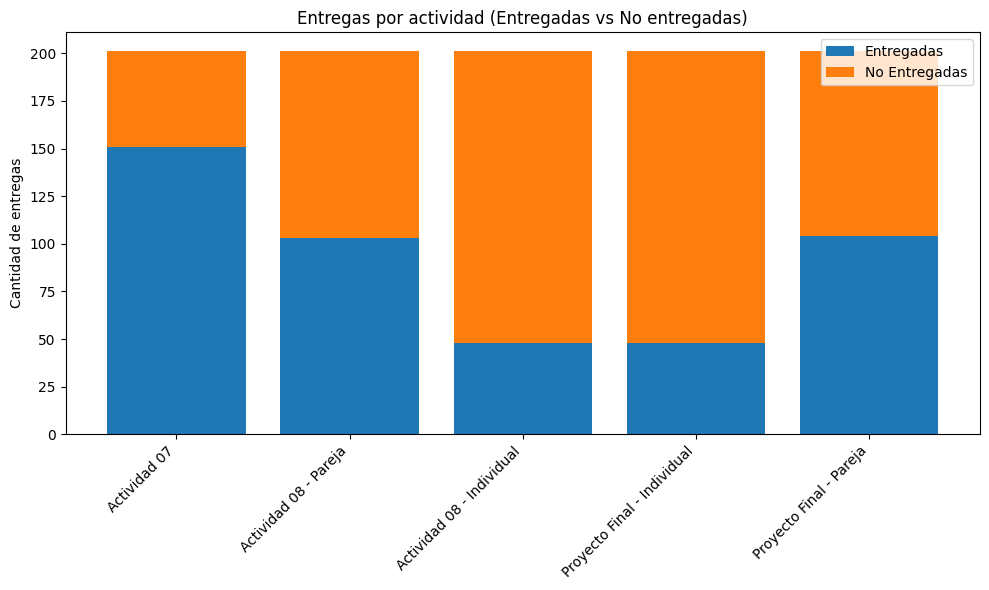

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display


# Construcción automática de la tabla de resumen desde variables existentes
datos_resumen = [
    ["Actividad 07",                      num_not_menosuno,        num_menosuno,        num_no_entregado,        num_not_menosuno],
    ["Actividad 08 - Pareja",            not_menosuno_pareja,     menosuno_pareja,     no_entregado_pareja,     entregado_pareja],
    ["Actividad 08 - Individual",        not_menosuno_individual, menosuno_individual, no_entregado_individual, entregado_individual],
    ["Proyecto Final - Individual",      not_menosuno_final_ind,  menosuno_final_ind,  no_entregado_final_ind,  entregado_final_ind],
    ["Proyecto Final - Pareja",          not_menosuno_final_par,  menosuno_final_par,  no_entregado_final_par,  entregado_final_par],
]

df_resumen = pd.DataFrame(datos_resumen, columns=[
    "Actividad",
    "Notas ≠ -1",
    "Notas = -1",
    "No Entregadas",
    "Entregadas"
])

display(df_resumen)

# Gráfico de barras apiladas
fig, ax = plt.subplots(figsize=(10, 6))

labels = df_resumen["Actividad"]
entregadas = df_resumen["Entregadas"]
no_entregadas = df_resumen["No Entregadas"]

ax.bar(labels, entregadas, label="Entregadas")
ax.bar(labels, no_entregadas, bottom=entregadas, label="No Entregadas")

ax.set_ylabel("Cantidad de entregas")
ax.set_title("Entregas por actividad (Entregadas vs No entregadas)")
ax.legend()
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()



### 3. Escritura del dataframe y estadísticas básicas

In [10]:
# Guardar dataframe estandarizado de assign
df_assign_completo.write.parquet(f"{PATH_INTERMEDIATE_STD}/assign_std.parquet", mode="overwrite")

# Estadísticas por estudiante
print("Estadísticas de tareas tipo assign por estudiantes:")
print("====================================================\n")

from pyspark.sql.functions import count, avg, col, when

df_assign_stats = df_assign_completo.groupBy("userid").agg(
    count(when(col("entregado") == 1, True)).alias("entregas_realizadas"),
    count(when(col("entregado") == 0, True)).alias("entregas_no_realizadas"),
    avg(when(col("entregado") == 1, col("nota"))).alias("nota_media_entregada"),
    count(when(col("nota") == -1.0, True)).alias("tareas_nota_menos_1")
)

df_assign_stats.show(300, truncate=False)



Estadísticas de tareas tipo assign por estudiantes:

+----------------------------------------------------------------+-------------------+----------------------+--------------------+-------------------+
|userid                                                          |entregas_realizadas|entregas_no_realizadas|nota_media_entregada|tareas_nota_menos_1|
+----------------------------------------------------------------+-------------------+----------------------+--------------------+-------------------+
|e1f1d0f48ca77093f9d66cefd325504245277db3e6c14504a25fda693e82a393|5                  |5                     |4.3                 |1                  |
|90a634296aff946e9d045997d512d2b77dbc01880715c1e179eafed0ec78378c|2                  |8                     |4.0                 |1                  |
|b5de2bb5b8538b199d6b3f0ecb32daa8a9d730ccc484dba45f756a59254c6dbe|4                  |6                     |5.75                |0                  |
|b6b2a12e84ea8203775195ed2bb4e99c57880537